# Regression Using NLP: Beers, Ratings, and Reviews

## Group:
- Danny Quang
- Alex Jensen
- George Gavrilov
- Vedan Desai

In [1]:
###Loading up necessary libraries 
import gzip
from collections import defaultdict
import math
import scipy.optimize
import numpy
import string
import random
from sklearn import linear_model
import pandas as pd
import seaborn as sns
import numpy as np

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
analyser = SentimentIntensityAnalyzer()

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import SplineTransformer
from sklearn.neural_network import MLPRegressor

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

import matplotlib.pyplot as plt

from numba import jit
import csv
import json

## Introduction & Light Cleaning
This project is an analysis of natural text in order to produce a rating. We're using the RateBeer dataset from the recommended datasets listed in class. This dataset, as explored in the EDA section below, consists of ~292K reviews for beer with each review stored as an observation. Our work in this project entails only two of this dataset's features, however. First, the 'review/text' column which stores a user's text review of the beer in question, and then the 'review/overall' column which stores the user's rating of the beer out of 20. The first is a very messy, but, in our belief, very informational feature that could lead to insights into the second. Regardless, without further ado let's begin discussing the task.

### Task: Predict a beer's rating given its review
There are several ways we could break this task down. We could convert the 'review/overall' column into a list of letter grades for instance, from A-F, which could follow any grading format's cutoffs (ie. 90+ = A, 80 - 90 = B, 70 - 80 = C, 60 - 70 = D, 60> = F). Of we could use some other kind of cutoff to convert this from a regression task to a classification task, however all of these options are what can be called mostly extraneous. Really the purpose of this task is to use the natural language processing methods taught in class to create a valid model that is at least somewhat able to predict a rating given a review. There are several models we intend to test against the baseline (in this case we'll set the baseline to be a bag of words model since that's the first method of text processing taught in class). The models we intend to test are listed below:
1. Bag of words + linear regression (baseline)
2. TF-IDF + linear regression
3. Sentiment analysis + linear regression
4. TF-IDF + MLP
5. Sentiment analysis + splines + linear regression

All of these models will be hyper-parameterized using a gridsearch and as such should achieve relatively solid performance on the test set. Ultimately we expect that the latter 5 should definitely outperform the former, but in the world of machine learning nothing is ever certain. Still for now, we move into cleaning:

In [2]:
# Function from homeworks/assignments that will come in handy
def parse(f):
    for l in gzip.open(f):
        yield eval(l)

First we load the data up into a pandas dataframe:

In [3]:
dataset = list(parse("ratebeer.json.gz"))
beer_data = pd.DataFrame(dataset)
beer_data.head()

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text
0,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,4/5,6/10,3/5,6/10,13/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."
1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,4/5,6/10,4/5,7/10,13/20,1157241600,TomDecapolis,On tap at the John Harvards in Springfield PA....
2,John Harvards Cristal Pilsner,71716,8481,5,Bohemian Pilsener,4/5,5/10,3/5,6/10,14/20,958694400,PhillyBeer2112,"UPDATED: FEB 19, 2003 Springfield, PA. I've ne..."
3,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,1157587200,TomDecapolis,On tap the Springfield PA location billed as t...
4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."


Next we'll check to see how clean the data is in terms of null-valued entries:

In [4]:
beer_data.isna().sum().sum()

13

In [5]:
beer_data.isna().sum()

beer/name             1
beer/beerId           1
beer/brewerId         1
beer/ABV              1
beer/style            1
review/appearance     1
review/aroma          1
review/palate         1
review/taste          1
review/overall        1
review/time           1
review/profileName    1
review/text           1
dtype: int64

In [6]:
beer_data.iloc[-1]

beer/name             NaN
beer/beerId           NaN
beer/brewerId         NaN
beer/ABV              NaN
beer/style            NaN
review/appearance     NaN
review/aroma          NaN
review/palate         NaN
review/taste          NaN
review/overall        NaN
review/time           NaN
review/profileName    NaN
review/text           NaN
Name: 2924163, dtype: object

It appears as though the data is remarkably clean with the exception of one row, the last one. So we remove that:

In [7]:
beer_data = beer_data[:-1]

Next we check data types:

In [8]:
beer_data.dtypes

beer/name             object
beer/beerId           object
beer/brewerId         object
beer/ABV              object
beer/style            object
review/appearance     object
review/aroma          object
review/palate         object
review/taste          object
review/overall        object
review/time           object
review/profileName    object
review/text           object
dtype: object

Clearly this won't do since the numerical review columns are typed as strings, so we should convert them to numerical representations:

In [9]:
def make_review_numerical(df, review_col):
    denom = int(df[review_col].iloc[0].split('/')[-1])
    return df[review_col].str.split('/').str[0].astype(int)/denom
rating_cols = ['review/appearance', 'review/aroma', 'review/palate', 'review/taste', 'review/overall']
for i in rating_cols:
    beer_data[i] = make_review_numerical(beer_data, i)

Looks like it worked! We check below by displaying the first 5 elements of the dataframe:

In [10]:
beer_data[rating_cols].head()

,review/appearance,review/aroma,review/palate,review/taste,review/overall
0,0.8,0.6,0.6,0.6,0.65
1,0.8,0.6,0.8,0.7,0.65
2,0.8,0.5,0.6,0.6,0.70
3,0.4,0.4,0.4,0.4,0.40
4,0.4,0.4,0.4,0.4,0.40


# Exploratory Data Analysis

Now that we have a numerical column to predict, we can do some analysis of these newly obtained columns:

In [11]:
beer_data[rating_cols].describe()

,review/appearance,review/aroma,review/palate,review/taste,review/overall
count,2.924163e+06,2.924163e+06,2.924163e+06,2.924163e+06,2.924163e+06
mean,6.864054e-01,6.353608e-01,6.514471e-01,6.451929e-01,6.599848e-01
std,1.625114e-01,1.639165e-01,1.659462e-01,1.622888e-01,1.676290e-01
min,2.000000e-01,1.000000e-01,2.000000e-01,1.000000e-01,5.000000e-02
25%,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01
50%,6.000000e-01,7.000000e-01,6.000000e-01,7.000000e-01,7.000000e-01
75%,8.000000e-01,7.000000e-01,8.000000e-01,8.000000e-01,7.500000e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


So it looks like the average is a little lower than the median which indicates that the data is skewed to the left. In addition it looks like most beers get a rating in between 12 and 15 out of 20, which goes to show that this might be approximately normal. To be sure, let's plot a histogram of the overall column:

<AxesSubplot: >

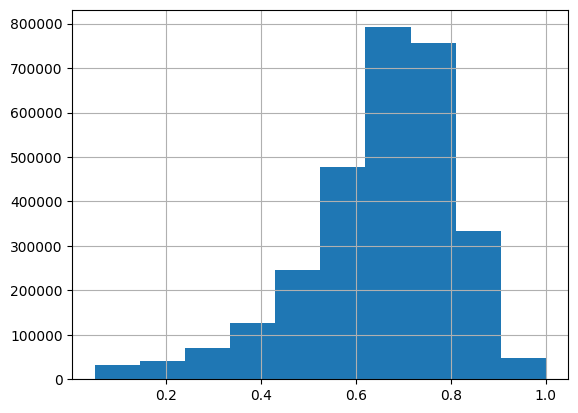

In [12]:
beer_data['review/overall'].hist()

The histogram above is the definition of a left skew. In other words any model that predicts most ratings in the IQR described above should do pretty well. But now that we have an understanding of the data's shape, and now that we know linear regression will probably work, we can move on to doing some EDA for the first of our approaches: Sentiment analysis. The sentiment analysis model we're using is VADER, or the Valence Aware Dictionary for sEntiment Reasoning. It's relatively advanced as a sentiment analysis model since it examines not only positivity or negativity but also intensity. A weakness of VADER is that it is trained primarily on Twitter data, however in our case that might be a strength given that the RateBeer website is basically a social media website for beer.

We run the function below to get the sentiment for each review in the dataset. However since this takes ~14 minutes to complete on the full dataset, we save the output to a .txt file and read that in as a csv instead. The below code can simply be uncommented to go through the process of creating the sentiment dataset.

In [13]:
# The below code takes ~14 minutes and 42 seconds to run on the full dataset
def get_sentiments(input_list):
    
    output = {}

    for sentence in input_list:
        ss = analyser.polarity_scores(sentence)
        ss['sentence'] = sentence
        for key in ss:
            if key in output:
                output[key] += [ss[key]]
            else:
                output[key] = [ss[key]]

    return pd.DataFrame(output)
#beer_data_reviews = list(beer_data['review/text'].values)
#sentiments = get_sentiments(beer_data_reviews)
#dct = sentiments.to_dict()
#with open('sentiment.txt', 'w') as file:
     #file.write(json.dumps(dct))

In [14]:
# this code only takes 1 minute and 35 seconds to run
with open('sentiment.txt', 'r') as file:
    contents = file.read()
sentiments = pd.DataFrame(eval(contents))
sentiments['sentence'] = sentiments['sentence'].str[1:-1]

Just to make sure this sentiment analysis is working, let's take a look at the most negatively classified sentence in comparison to the most positively classified sentence:

In [15]:
#This line of code gets most negatively classified sentence
sentiments.sort_values(by='compound').iloc[0]['sentence']

'NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO.'

In [16]:
#This line of code gets most positively classified sentence
sentiments.sort_values(by='compound').iloc[-1]['sentence']

'UPDATED: JAN 24, 2011 2006 Vintage\t3/01/2007:  Well, the Duck-Rabbit Barleywine tasted more like "Bandywine", but Ross redeemed himself one this one.  Apparently the bottle he sent me is approaching a year old and it was awesome right now...\tDuck-Rabbit Wee Heavy Scotch Style Ale pours a clear dark amber color.  It has an ample amount of carbonation, but it isnt over done.  Initially there is a small honey-colored head, but it quickly diminishes and leaves only a partial film.  This stuff \tlooks pretty thick; the bubbles rise slowly to the surface through the viscous beer...  The aroma is sweet, deeply malty and contains a complex blend of aged fruit, caramel/chocolate, and fine alcohol.  The flavor is rich, full, malty, and complex.  Flavors of aged dark fruit, something darker like caramel and/or chocolate, and reminants of subltle smoke blend into an amazing experience.  The alcohol is extremely well integrated into the overall flavor and barely noticeable.  The mouthfeel is thi

In [17]:
sentiments.head()

,neg,neu,pos,compound,sentence
0,0.044,0.909,0.047,0.0571,"On tap at the Springfield, PA location. Poured..."
1,0.044,0.956,0.000,-0.4549,On tap at the John Harvards in Springfield PA....
2,0.150,0.780,0.069,-0.6310,"UPDATED: FEB 19, 2003 Springfield, PA. I've ne..."
3,0.048,0.845,0.108,0.4779,On tap the Springfield PA location billed as t...
4,0.000,0.928,0.072,0.6249,"On tap at the Springfield, PA location. Poured..."


So it looks like the VADER model is working about as well as we could hope. For reference the closer to 1 a score is the more positive that sentiment is. The closer to -1, the more negative that sentiment is. Next let's get a read on how positive or negative our dataset is as a whole so we can get an understanding of how useful this score would be to predicting ratings:

In [18]:
sentiments.describe()

,neg,neu,pos,compound
count,2.924163e+06,2.924163e+06,2.924163e+06,2.924163e+06
mean,4.936293e-02,7.873712e-01,1.615468e-01,4.863904e-01
std,6.103293e-02,1.116618e-01,1.027245e-01,4.800538e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,-9.994000e-01
25%,0.000000e+00,7.230000e-01,9.100000e-02,1.970000e-01
50%,3.500000e-02,7.930000e-01,1.540000e-01,6.705000e-01
75%,7.800000e-02,8.590000e-01,2.240000e-01,8.720000e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,9.999000e-01


<AxesSubplot: xlabel='compound', ylabel='Count'>

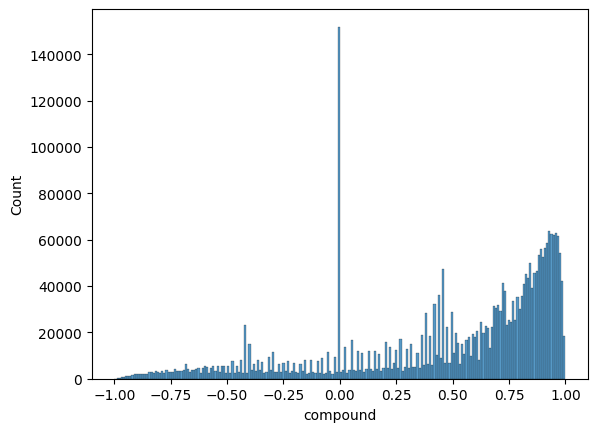

In [19]:
sns.histplot(x=sentiments['compound'])

In typical sentiment analysis fashion, there is a large number of completely neutral valued scores. This is probably not because these reviews have no sentiment (although that could be the rare case), instead this is because VADER was unable to detect a sentiment from these reviews. So this is actually a weakness of our method of assigning sentiment. Although in this case, this may not be a terrible aspect of our sentiment analysis because a large portion of the ratings also lie in the neutral/average range (12-15 out of 20). So as far as using sentiment as a predictor goes we may be on to something. Another interesting thing to note is that the sentiment is skewed left, meaning that there are more positive than negative reviews. That may be the real detractor from this analysis. However, let us make sure this is the case by checking the correlation between sentiment and rating.

In [20]:
### df is the original 'beer_data' dataframe with the sentiment scores appended for each review
df = pd.merge(beer_data, sentiments, left_on='review/text', right_on='sentence', how='inner').drop(columns=['sentence'])
df = df.drop_duplicates().reset_index(drop=True)
df.head()

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text,neg,neu,pos,compound
0,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,0.8,0.6,0.6,0.6,0.65,1157587200,hopdog,"On tap at the Springfield, PA location. Poured...",0.044,0.909,0.047,0.0571
1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,0.8,0.6,0.8,0.7,0.65,1157241600,TomDecapolis,On tap at the John Harvards in Springfield PA....,0.044,0.956,0.000,-0.4549
2,John Harvards Cristal Pilsner,71716,8481,5,Bohemian Pilsener,0.8,0.5,0.6,0.6,0.70,958694400,PhillyBeer2112,"UPDATED: FEB 19, 2003 Springfield, PA. I've ne...",0.150,0.780,0.069,-0.6310
3,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,0.4,0.4,0.4,0.4,0.40,1157587200,TomDecapolis,On tap the Springfield PA location billed as t...,0.048,0.845,0.108,0.4779
4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,0.4,0.4,0.4,0.4,0.40,1157587200,hopdog,"On tap at the Springfield, PA location. Poured...",0.000,0.928,0.072,0.6249


<AxesSubplot: xlabel='compound', ylabel='review/overall'>

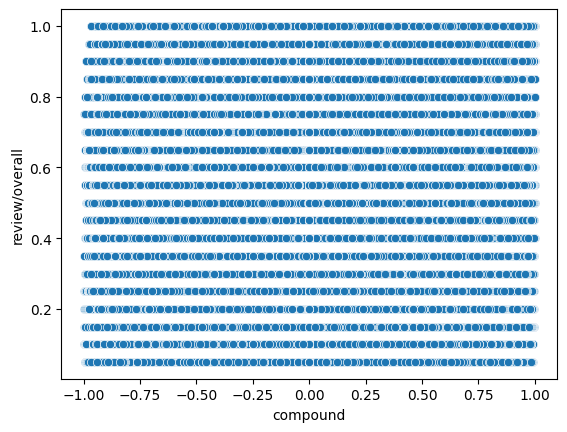

In [21]:
sns.scatterplot(data=df, y=df['review/overall'], x=df['compound'])

And suddenly this avenue of investigation seems completely fruitless. There is absolutely no observable correlation between how positively or negatively classified a review is and the resulting rating the user gives to the beer. There is of course one main limitation here, and that is VADER. While VADER is basically state of the art outside of a neural network or other more complex form of ML, it can still, as mentioned previously, fail to detect sentiment. Still, let's check on the correlation coefficient before we completely abandon this avenue of investigation:

In [22]:
df['compound'].corr(df['review/overall'])

0.39294814135352374

That's actually a surprisingly high score given the visualization, but still below what we would hope for. Predicting using solely this feature may not be the most effective although perhaps we could use the sentiment in a larger pipeline to arrive at a better prediction, if it is not redundant as a feature. Maybe an SVM would be useful here?

Next up we'll move on to some EDA through a TF-IDF lens. TF-IDF, or term frequency-inverse document frequency is a way of processing text data that rewards words that occur frequently in any individual sentence while punishing words that occur frequently in the entire document. While there isn't a really easy way to visualize how effective TF-IDF is, we can kind of get an understanding for how effective TF-IDF will be by checking out which words occur based on how highly rated a beer is. One easy and visually appealing way to do this is word clouds. The function below plots a wordcloud using the full text columnn given the beer dataset:

In [23]:
def create_wordcloud(df):
    stopwords = set(STOPWORDS)
    punctuation = set(string.punctuation)
    text = ' '.join(df['review/text']
                    .str.replace('[^\w\s]',' ', regex=True)
                    .str.replace('  ', ' ', regex=False)
                    .str.lower()
                   )
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.figure( figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

We bin the beers into 5 categories. Beers that are rated above a 0.8, beers that are rated between 0.6 and 0.8, beers that are rated between 0.4 and 0.6, beers between 0.2 and 0.4, and finally beers rated above a 0.2. All of these categories are exclusively lower bounded and inclusively upper bounded. Rather than discussing each word cloud individually, we'll comment on them at the very end of this section.

In [24]:
excellent_beers = df[df['review/overall'] > 0.8]
good_beers = df[(df['review/overall'] <= 0.8) & (df['review/overall'] > 0.6)]
mediocre_beers = df[(df['review/overall'] <= 0.6) & (df['review/overall'] > 0.4)]
poor_beers = df[(df['review/overall'] <= 0.4) & (df['review/overall'] > 0.2)]
terrible_beers = df[df['review/overall'] <= 0.2]

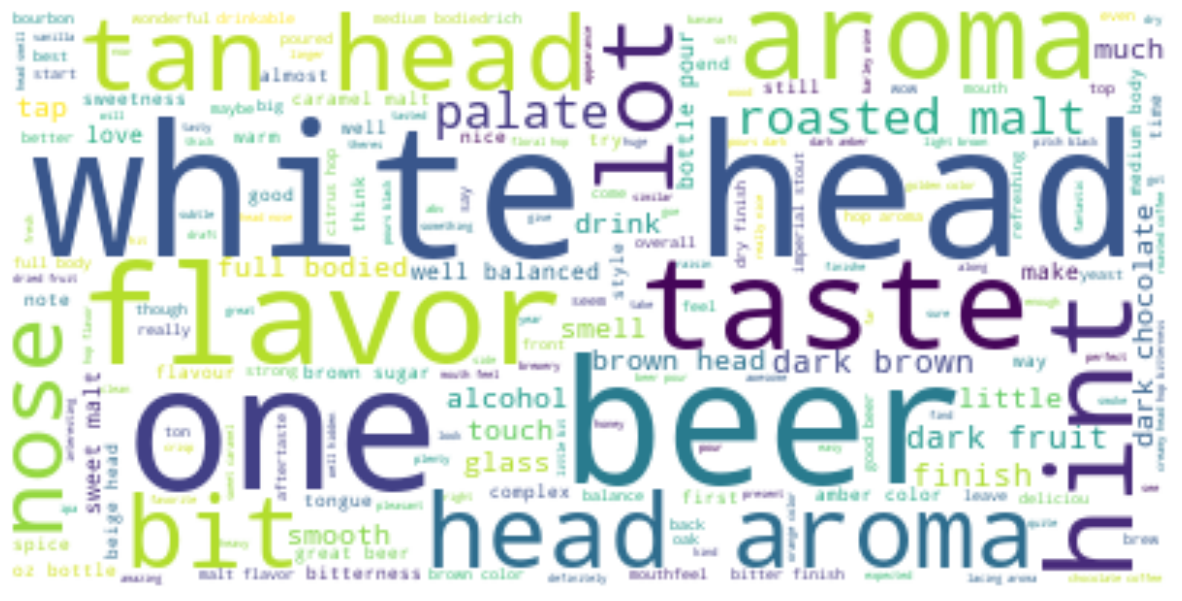

In [25]:
create_wordcloud(excellent_beers)

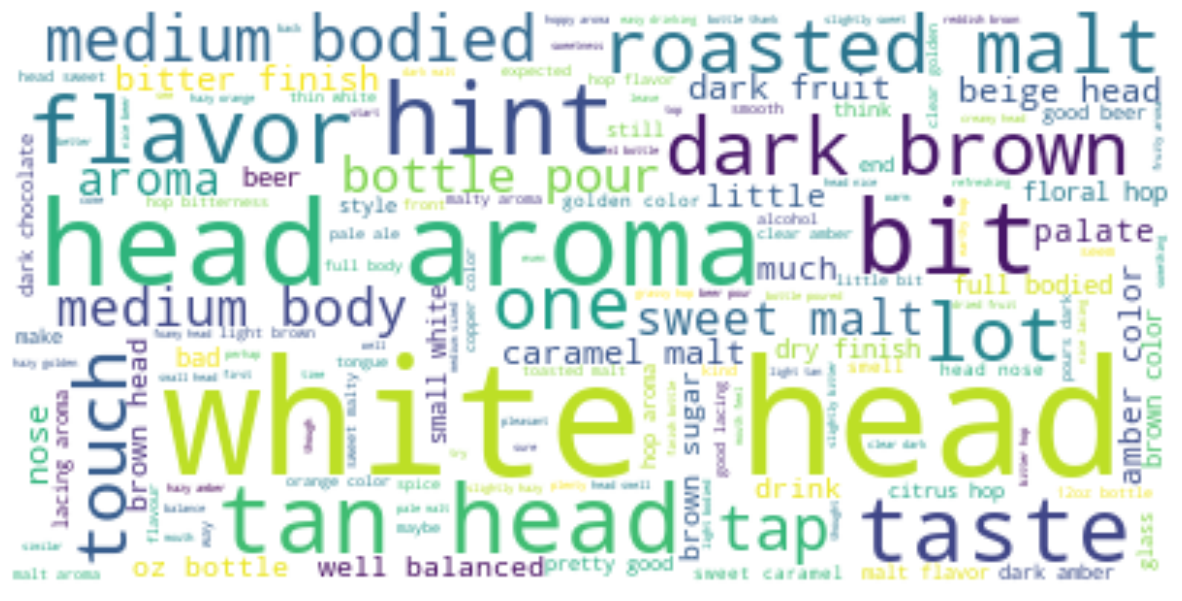

In [26]:
create_wordcloud(good_beers)

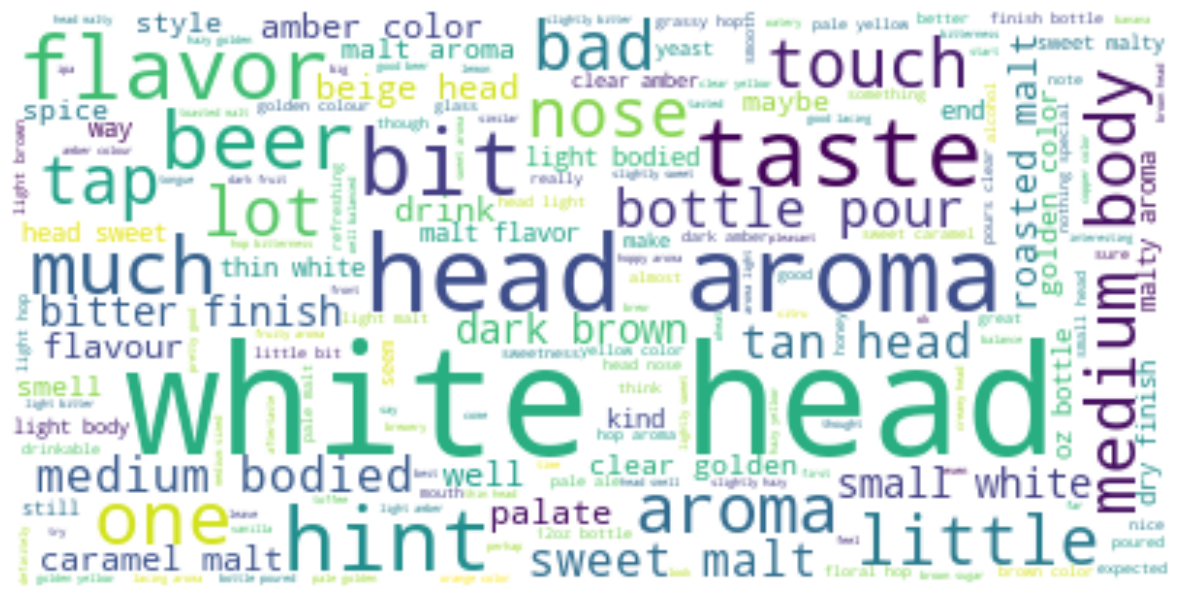

In [27]:
create_wordcloud(mediocre_beers)

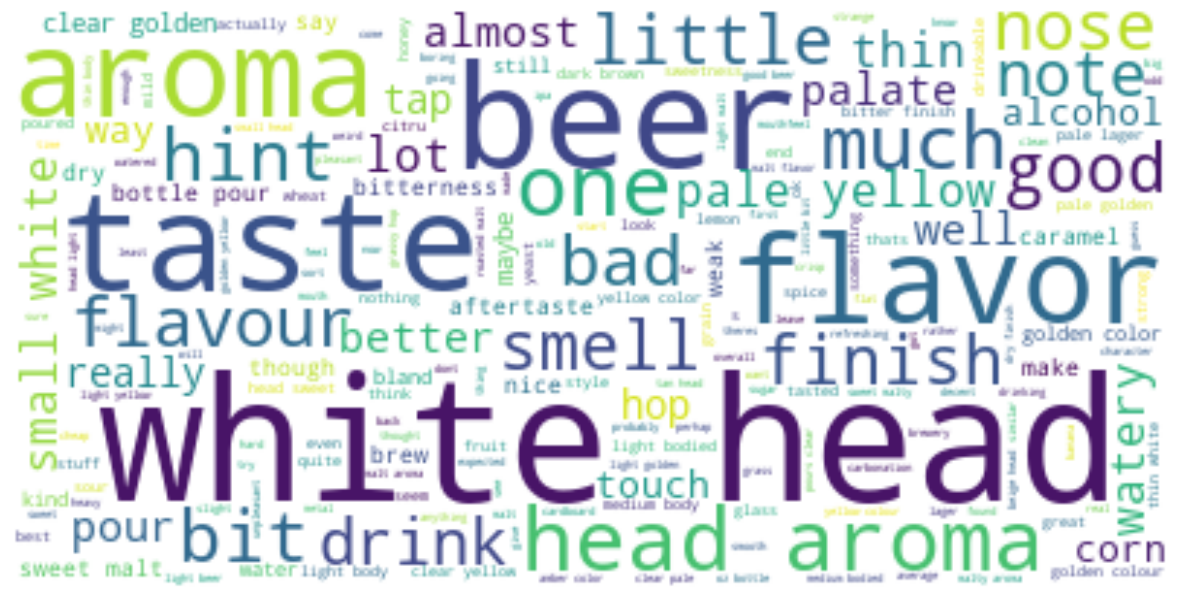

In [28]:
create_wordcloud(poor_beers)

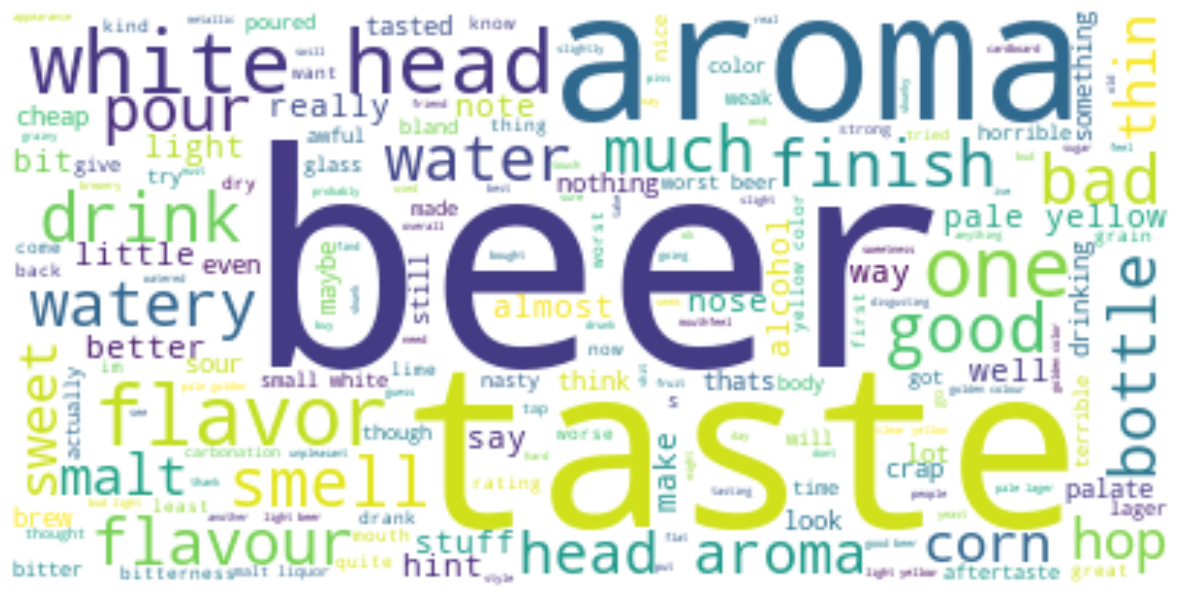

In [29]:
create_wordcloud(terrible_beers)

So it seems that some words occur really frequently throughout the whole dataset. These include the obvious like beer, aroma, and flavor, and then the more odd occurrences like white, and head. However the beauty of this particular visualization is that if one ignores the largest words that occur really frequently throughout the dataset it looks like TF-IDF might actually be the best choice for this model. This is mainly because of the smaller words above. For example, the worst rated beers have a high occurence of words like water/watery, bad, thin, and little. Meanwhile the word cloud for the best rated beers sounds...delicious. There may not be a better way to phrase it. Still as far as changes this word cloud visualization has given us insight into for the model, there are really two things: First, stemming might yield better results for TF-IDF in this case. These users seem to use a lot of the same adjective-verb-noun conjugates to describe how good/bad a beer is. In addition, cleaning the text as we have above will be absolutely necessary. Regardless that concludes our EDA, and so we move on to our modeling.

# Modeling

Now that we've explored the data enough to get a good read on some features that *may* work, let us move into the modeling. As mentioned in the introduction there are 5 models we will try, listed again here:

1. Bag of words + linear regression (baseline)
2. TF-IDF + linear regression
3. Sentiment analysis + linear regression
5. TF-IDF + MLP
6. Sentiment analysis + splines + linear regression

All of these models will be run as pipelines through sklearn and hyperparameterized using a gridsearch (also from sklearn). It is our expectation that the TF-IDF + SVM will outperform all the other models, given the results of our EDA. The baseline to beat in our case is the bag of words with a linear regression run on it.

We'll be using a subset of our dataframe moving forward since otherwise we run into memory issues while running our code:

In [30]:
sample_df = df.sample(frac=0.25)

First up, we'll do a simple bag of words with an additional linear regression and see how that performs.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(sample_df['review/text'], sample_df['review/overall'], test_size=0.33, random_state=42)
bow = CountVectorizer()
lr = linear_model.LinearRegression()
new_train = bow.fit_transform(X_train)
new_test = bow.transform(X_test)
lr.fit(new_train, y_train)
score = lr.score(new_test, y_test)
print("A basic bag of words driven linear regression has the following accuracy: ", score)

A basic bag of words driven linear regression has the following accuracy:  0.25401355741029397


So the score to beat is an accuracy of 0.25, which honestly should not be too challenging. We should see immediate improvement with a TF-IDF approach:

In [32]:
X_train, X_test, y_train, y_test = train_test_split(sample_df['review/text'], sample_df['review/overall'], test_size=0.33, random_state=42)
bow = TfidfVectorizer()
lr = linear_model.LinearRegression()
new_train = bow.fit_transform(X_train)
new_test = bow.transform(X_test)
lr.fit(new_train, y_train)
score = lr.score(new_test, y_test)
print("A TF-IDF driven linear regression has the following accuracy: ", score)

A TF-IDF driven linear regression has the following accuracy:  0.3748185471702824


And just like that we've beaten the baseline. Now there are a few variants of TF-IDF feature extraction we'd like to try. First up, we'll try stemming the words and seeing if that yields an overall improvement (using code from https://www.kaggle.com/code/xfffrank/tfidf-stemming):

In [33]:
def tokenize(raw):
    return [w.lower() for w in word_tokenize(raw) if w.isalpha()]

class StemmedTfidfVectorizer(TfidfVectorizer):
    en_stemmer = SnowballStemmer('english')
    
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: (StemmedTfidfVectorizer.en_stemmer.stem(w) for w in analyzer(doc))
    
tfidf = StemmedTfidfVectorizer(tokenizer=tokenize, analyzer="word")
lr = linear_model.LinearRegression()
new_train = tfidf.fit_transform(X_train)
new_test = tfidf.transform(X_test)
lr.fit(new_train, y_train)
score = lr.score(new_test, y_test)
print("A TF-IDF driven linear regression with stemming has the following accuracy: ", score)

A TF-IDF driven linear regression with stemming has the following accuracy:  0.4370506199741664


So stemming appears to increase performance by a good 7% on this sample subset of our data. Next up let's try out our sentiment analysis model:

In [34]:
X_train, X_test, y_train, y_test = train_test_split(sample_df[['compound']], sample_df['review/overall'], test_size=0.33, random_state=42)
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
score = lr.score(X_test, y_test)
print("A simple sentiment analysis driven linear regression with stemming has the following accuracy: ", score)

A simple sentiment analysis driven linear regression with stemming has the following accuracy:  0.15393457324627458


So that didn't work nearly as well as the TF-IDF or bag of words approaches. Next we'll take this into a more complicated realm by trying out several different models instead of a simple linear regressor. 

In [35]:
X_train, X_test, y_train, y_test = train_test_split(sample_df[['compound']], sample_df['review/overall'], test_size=0.33, random_state=42)
pipe = Pipeline(steps=([('splines', SplineTransformer()), 
                        ('lr', linear_model.LinearRegression())])
               )
params = {'splines__degree': [2, 3, 4, 5], 'splines__n_knots': list(range(2, 20))}
gs = GridSearchCV(pipe, params, n_jobs = -1)
gs.fit(X_train, y_train)
score = gs.score(X_test, y_test)
best_params = gs.best_params_
best_score = gs.best_score_
print("Our best splines model found using a gridsearch with 5-fold cross-validation has the following params: ", best_params)
print("This model has a corresponding score on the training set of: ", best_score)
print("This model has a score on the test set of: ", score)

Our best splines model found using a gridsearch with 5-fold cross-validation has the following params:  {'splines__degree': 5, 'splines__n_knots': 19}
This model has a corresponding score on the training set of:  0.17355635722040524
This model has a score on the test set of:  0.1727830289855523


In the above cell we try to hyperparameterize and train what is called a spline on the data. A spline is basically a means of taking a linear regression out of the linear world and into a more well-fit world. Splines can often run into the problem of being overfit, but (un)luckily, the sentiment analysis model is so bad it doesn't matter anyways. Next we'll try to fit a multi-layer perceptron regressor on the TF-IDF data in order to get a better result. This MLP is a very simple implementation taken from Sklearn, and so it isn't exactly finetuned for the task at hand. However we expect to see better results here regardless:

In [ ]:
model = MLPRegressor(activation='relu', warm_start=True, early_stopping=True)
params = {'hidden_layer_sizes': [100, 200, 300, 400]}
gs = GridSearchCV(model, params, n_jobs = -1)
gs.fit(new_train, y_train)
score = gs.score(new_test, y_test)
best_params = gs.best_params_
best_score = gs.best_score_
print("Our best MLP model found using a gridsearch with 5-fold cross-validation has the following params: ", best_params)
print("This model has a corresponding score on the training set of: ", best_score)
print("This model has a score on the test set of: ", score)

print("A TF-IDF driven spline linear regression with stemming has the following accuracy: ", score)

The above cell seemingly runs into the occasional memory issues. As such we can't run it, but this should be the best model once hyperparameterized correctly. For now we will accept the TF-IDF into linear regression as our best model. Ultimately in order of prediction strength we find that the order goes as follows:
1. TF-IDF + linear regression
2. bag of words + linear regression
3. Sentiment analysis + splines + linear regression
4. Sentiment analysis + linear regression

This is somewhat unexpected. Sentiment was thought to be an ultimate predictor of the rating, and that is proven to be false. Furthermore a simple bag of words model beats out our sentiment analysis, which is quite unfortunate. Again this could be due to issues in VADER, there are certainly more robust models that we could've used instead, but in such a case the task would likely become gleaning sentiment instead of predicting rating. However we did expect, by looking at the word clouds that TF-IDF would outperform its competitors.

# Literature Review

We found our dataset on the website of RateBeer, a website that allows its users to rate breweries, bars, and beer from 1 to 5 stars, usually accompanied with a text review of the object in question. We mainly focused on beer, so our reviews were filtered only for individual beers. There are other papers that use the dataset for other purposes as well. Danescu-Niculescu-Mizil et al. uses the dataset to study the evolution of community-specific lingo, classifying stages of a community from a “linguistically innovative learning phase” to a “conservative phase,” creating new terms for a community and then making little to no changes about terminology or the diction of the community. McAuley and Leskovec explore the dataset to learn how to predict the rating of a user while taking into account the user’s experience level, which is mostly non-decreasing and may affect the user’s rating based on expertise. 

There are also similar datasets that expanded beyond user rating. Oyebode, Alqahtani, and Orji applied rating prediction for mental health app reviews in an attempt to classify reviews that lack a star rating as well as to identify key “themes” that ultimately contributed to a favorable or unfavorable rating. Tang et al. uses Yelp and Rotten tomatoes reviews, which carry a vital review text feature as well. 

There are also some more complex and recent methods to study text based data as well, with the most common ones being a deep learning model, as well as more classical/older methods which involve a bag of words and tf-idf feature engineering. Minaee et al. analyze various deep learning models, with the most frequent ones being recurrent neural networks (RNN) and convolutional neural networks (CNN), which are both attempts to use contextual information in order to create a more useful feature space. 
An interesting method also exists for classifying reviews. One paper by Tang et al. uses Yelp and Rotten Tomatoes reviews to create a better review prediction model through building a model that vectorizes both the user and words in the review in attempt to capture a user’s sentiment when using relative words that have “different sentimental strengths” such as “good”. By multiplying a user’s matrix with word vectors, they obtain a new vector with an activation function applied to it, which eventually condenses into a single document vector by a recursive biTanh function which applies the tanh function to two vectors added together. Weights and biases are then trained on this singular vector to accurately predict a review’s rating.

Works Cited:

- Danescu-Niculescu-Mizil, Robert West, Dan Jurafsky, Jure Leskovec, and Christopher Potts. 2013. No country for old members: user lifecycle and linguistic change in online communities. In Proceedings of the 22nd international conference on World Wide Web (WWW '13). Association for Computing Machinery, New York, NY, USA, 307–318. https://doi.org/10.1145/2488388.2488416

- O. Oyebode, F. Alqahtani and R. Orji, "Using Machine Learning and Thematic Analysis Methods to Evaluate Mental Health Apps Based on User Reviews," in IEEE Access, vol. 8, pp. 111141-111158, 2020, doi: 10.1109/ACCESS.2020.3002176.

- Shervin Minaee, Nal Kalchbrenner, Erik Cambria, Narjes Nikzad, Meysam Chenaghlu, and Jianfeng Gao. 2021. Deep Learning--based Text Classification: A Comprehensive Review. ACM Comput. Surv. 54, 3, Article 62 (April 2022), 40 pages. https://doi.org/10.1145/3439726

- F. Rustam, A. Mehmood, M. Ahmad, S. Ullah, D. M. Khan and G. S. Choi, "Classification of Shopify App User Reviews Using Novel Multi Text Features," in IEEE Access, vol. 8, pp. 30234-30244, 2020, doi: 10.1109/ACCESS.2020.2972632.

- Duyu Tang, Bing Qin, Ting Liu, and Yuekui Yang. User Modeling with Neural Network for Review Rating Prediction. https://www.aaai.org/ocs/index.php/IJCAI/IJCAI15/paper/viewPaper/11051

# Conclusion

Our model performs worse than most of the deep learning approaches mentioned in the literature above, and only marginally worse than traditional classical machine learning methods. Ultimately we do outperform our baseline rather significantly, although the results do seem to tell us that we are some ways off from being able to accurately model ratings from review text. The feature representation that works best is TF-IDF with stemming, although unfortunately we weren't able to hyperparameterize this representation further due to memory issues. I would say that none of the models succeeded, but not because we were going in the wrong direction. Rather, the code is just inefficient and hyperparameterization is too expensive to commit to on large matrices, especially given a dataset the size of RateBeer. In addition, the task of regression also adds another level of difficulty. If we had binned and aimed for classification, perhaps our model would have been more effective given that text lends itself better to classification than regression tasks, as touched on in the literature review. Ultimately this is a project worth revisiting, just to see if we can achieve a reasonable accuracy, maybe when we don't have a deadline and gridsearch for days/weeks. 